# Phish Setlist Modeling - Data Prep

The purpose of this notebook is document the data prep workflow for munging data into sequences for a LSTM neural network. To recreate the MVP modeling data yourself, run the make_dataset.py script under src.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src

Using TensorFlow backend.


## Load in Raw Setlist Data

**NOTE** - These datasets were extracted from the Phish.net API using the pyphishnet API wrapper found here: https://github.com/areed1242/pyphishnet.git

In [17]:
# load data
all_setlists = src.util.load_pickle_object(r'../data/raw/extract-10082019/all_setlists.pkl')
#all_shows = src.util.load_pickle_object(r'../../data-extracts/extract-05032019/all_shows.pickle')

#### verify only Phish setlists

In [75]:
all_setlists[all_setlists.artistid == 1].shape

(1752, 16)

In [76]:
all_setlists.shape

(1752, 16)

In [20]:
# reset index
all_setlists.reset_index(drop=True, inplace=True)

In [79]:
all_setlists.columns

Index(['artist', 'artistid', 'gapchart', 'location', 'long_date', 'rating',
       'relative_date', 'setlistdata', 'setlistnotes', 'short_date',
       'showdate', 'showid', 'url', 'venue', 'venueid', 'setlistdata_clean'],
      dtype='object')

In [81]:
all_setlists[['artistid', 'location', 'long_date', 'showid', 'venueid', 'setlistdata_clean']].tail()

,artistid,location,long_date,showid,venueid,setlistdata_clean
1747,1,"East Troy, WI, USA",Saturday 07/13/2019,1547482638,3,Set 1|AC/DC Bag|NICU|Shade|Funky Bitch|Blaze O...
1748,1,"East Troy, WI, USA",Sunday 07/14/2019,1547482678,3,Set 1|The Landlady|Olivia's Pool|The Man Who S...
1749,1,"Commerce City, CO, USA",Friday 08/30/2019,1547482701,961,Set 1|Can't Always Listen|Free|No Men In No Ma...
1750,1,"Commerce City, CO, USA",Saturday 08/31/2019,1547482724,961,Set 1|The Moma Dance|The Final Hurrah|Gumbo|Ac...
1751,1,"Commerce City, CO, USA",Sunday 09/01/2019,1547482744,961,Set 1|Stray Dog|Stealing Time From the Faulty ...


#### Inspect and clean problematic setlists

In [22]:
# inspect shows
for i, row in all_setlists.iterrows():
    print(row.setlistdata_clean)
    print()

Set 1|Long Cool Woman in a Black Dress|Proud Mary|In the Midnight Hour|Squeeze Box|Roadhouse Blues|Happy Birthday to You|Set 2|Scarlet Begonias|Fire on the Mountain

Set 1|Makisupa Policeman

Set 1|In the Midnight Hour|Wild Child|Jam|Bertha|Can't You Hear Me Knocking|St. Stephen Jam|Can't You Hear Me Knocking|Camel Walk|Eyes of the World|Whipping Post|Drums

Set 1|Jam|Wild Child|Bertha|Can't You Hear Me Knocking|Camel Walk|Jam|In the Midnight Hour|Scarlet Begonias|Fire|Fire on the Mountain|Makisupa Policeman|Slave to the Traffic Light|Spanish Flea|Don't Want You No More|Cities|Drums|Skippy the Wondermouse|Fluffhead|Encore|Eyes of the World

Set 1|Slave to the Traffic Light|Mike's Song|Dave's Energy Guide|You Enjoy Myself|Alumni Blues|Letter to Jimmy Page|Alumni Blues|Prep School Hippie|Run Like an Antelope

Set 1|Anarchy|Camel Walk|Fire Up the Ganja|Skippy the Wondermouse|In the Midnight Hour

Set 1|Sneakin' Sally Through the Alley

Set 1|Alumni Blues|Skippy the Wondermouse|Bertha|Jam|

Set 1|Also Sprach Zarathustra|Funky Bitch|Sparkle|Tweezer|Theme From the Bottom|Talk|Punch You in the Eye|Character Zero|A Day in the Life|Tweezer Reprise|Set 2|Ya Mar|Chalk Dust Torture|Bathtub Gin|Scent of a Mule|Free|The Lizards|The Star Spangled Banner|David Bowie|Encore|Golgi Apparatus

Set 1|Runaway Jim|Guelah Papyrus|The Old Home Place|Cars Trucks Buses|Stash|Strange Design|Divided Sky|Billy Breathes|Taste|Sample in a Jar|Set 2|Suzy Greenberg|Maze|You Enjoy Myself|Reba|Waste|Harry Hood|Encore|Julius

Set 1|My Friend, My Friend|Rift|Free|Esther|Llama|Gumbo|Down with Disease|Prince Caspian|Frankenstein|Set 2|AC/DC Bag|Sparkle|Slave to the Traffic Light|Bouncing Around the Room|Split Open and Melt|Fluffhead|Swept Away|Steep|Run Like an Antelope|Hello My Baby|Encore|Fee|Rocky Top

Set 1|The Star Spangled Banner|Sample in a Jar|Cars Trucks Buses|The Sloth|Divided Sky|Character Zero|Ginseng Sullivan|Stash|Waste|Possum|Set 2|Wilson|Chalk Dust Torture|Wolfman's Brother|Reba|Train Song|M

In [23]:
# create a new dataframe that has ONLY complete datasets (i.e. has Set 1, Set 2, and Encore)

complete_setlists = pd.DataFrame()

for i, row in all_setlists.iterrows():
    
    # get setlist as list
    setlist = row.setlistdata_clean.split('|')
    
    # Check for presence of Set 1, Set 2, and Encore
    if 'Set 1' and 'Set 2' and 'Encore' in setlist:
        complete_setlists = complete_setlists.append(row)    

In [24]:
print(f'{complete_setlists.shape[0]} of the {all_setlists.shape[0]} have a Set 1, Set 2, and Encore section')

1455 of the 1752 have a Set 1, Set 2, and Encore section


In [25]:
# reset index
complete_setlists.reset_index(drop=True, inplace=True)

In [26]:
complete_setlists.tail()

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistdata_clean,setlistnotes,short_date,showdate,showid,url,venue,venueid
1450,<a href='http://phish.net/setlists/phish'>Phis...,1.0,http://phish.net/setlists/gap-chart/phish-july...,"East Troy, WI, USA",Saturday 07/13/2019,3.7489,3 months ago,<p><span class='set-label'>Set 1</span>: <a hr...,Set 1|AC/DC Bag|NICU|Shade|Funky Bitch|Blaze O...,"This show was&nbsp;webcast via&nbsp;<a href=""h...",07/13/2019,2019-07-13,1.547483e+09,http://phish.net/setlists/phish-july-13-2019-a...,"<a href=""http://phish.net/venue/3/Alpine_Valle...",3.0
1451,<a href='http://phish.net/setlists/phish'>Phis...,1.0,http://phish.net/setlists/gap-chart/phish-july...,"East Troy, WI, USA",Sunday 07/14/2019,4.6001,3 months ago,<p><span class='set-label'>Set 1</span>: <a hr...,Set 1|The Landlady|Olivia's Pool|The Man Who S...,"This show was&nbsp;webcast via&nbsp;<a href=""h...",07/14/2019,2019-07-14,1.547483e+09,http://phish.net/setlists/phish-july-14-2019-a...,"<a href=""http://phish.net/venue/3/Alpine_Valle...",3.0
1452,<a href='http://phish.net/setlists/phish'>Phis...,1.0,http://phish.net/setlists/gap-chart/phish-augu...,"Commerce City, CO, USA",Friday 08/30/2019,3.7451,1 month ago,<p><span class='set-label'>Set 1</span>: <a hr...,Set 1|Can't Always Listen|Free|No Men In No Ma...,"This show was webcast via&nbsp;<a href=""http:/...",08/30/2019,2019-08-30,1.547483e+09,http://phish.net/setlists/phish-august-30-2019...,"<a href=""http://phish.net/venue/961/Dick%27s_S...",961.0
1453,<a href='http://phish.net/setlists/phish'>Phis...,1.0,http://phish.net/setlists/gap-chart/phish-augu...,"Commerce City, CO, USA",Saturday 08/31/2019,4.1429,1 month ago,<p><span class='set-label'>Set 1</span>: <a hr...,Set 1|The Moma Dance|The Final Hurrah|Gumbo|Ac...,"This show was webcast via&nbsp;<a href=""http:/...",08/31/2019,2019-08-31,1.547483e+09,http://phish.net/setlists/phish-august-31-2019...,"<a href=""http://phish.net/venue/961/Dick%27s_S...",961.0
1454,<a href='http://phish.net/setlists/phish'>Phis...,1.0,http://phish.net/setlists/gap-chart/phish-sept...,"Commerce City, CO, USA",Sunday 09/01/2019,4.0673,1 month ago,<p><span class='set-label'>Set 1</span>: <a hr...,Set 1|Stray Dog|Stealing Time From the Faulty ...,"This show was webcast via&nbsp;<a href=""http:/...",09/01/2019,2019-09-01,1.547483e+09,http://phish.net/setlists/phish-september-01-2...,"<a href=""http://phish.net/venue/961/Dick%27s_S...",961.0


In [27]:
# inspect shows
for i, row in complete_setlists.iterrows():
    print(row.setlistdata_clean)
    print()

Set 1|Jam|Wild Child|Bertha|Can't You Hear Me Knocking|Camel Walk|Jam|In the Midnight Hour|Scarlet Begonias|Fire|Fire on the Mountain|Makisupa Policeman|Slave to the Traffic Light|Spanish Flea|Don't Want You No More|Cities|Drums|Skippy the Wondermouse|Fluffhead|Encore|Eyes of the World

Set 1|Slave to the Traffic Light|Mike's Song|Dave's Energy Guide|Big Leg Emma|Set 2|Alumni Blues|Wild Child|Can't You Hear Me Knocking|Jam|Cities|Bring It On Home|Set 3|Scarlet Begonias|Eyes of the World|Whipping Post|McGrupp and the Watchful Hosemasters|Makisupa Policeman|Run Like an Antelope|The Other One|Encore|Anarchy

Set 1|Quinn the Eskimo|Have Mercy|Harry Hood|The Pendulum|Dave's Energy Guide|Icculus|You Enjoy Myself|Set 2|Help on the Way|Slipknot!|AC/DC Bag|McGrupp and the Watchful Hosemasters|Alumni Blues|Letter to Jimmy Page|Alumni Blues|Dear Mrs. Reagan|Encore|Not Fade Away

Set 1|Alumni Blues|Makisupa Policeman|Skin It Back|Cities|I Am Hydrogen|McGrupp and the Watchful Hosemasters|AC/DC Bag|

Set 1|Chalk Dust Torture|The Sloth|The Curtain|Waste|Loving Cup|What's the Use?|Wading in the Velvet Sea|Farmhouse|Nellie Kane|Taste|Rocky Top|Set 2|Peaches en Regalia|AC/DC Bag|Gumbo|Down with Disease|Frankenstein|Encore|Simple|Hello My Baby

Set 1|Ya Mar|Chalk Dust Torture|Farmhouse|First Tube|Carini|Dirt|Vultures|Sparkle|On Your Way Down|Beauty of My Dreams|Stash|Train Song|Billy Breathes|Run Like an Antelope|Set 2|Also Sprach Zarathustra|Mike's Song|I Am Hydrogen|Weekapaug Groove|Mountains in the Mist|Limb By Limb|Prince Caspian|Julius|Encore|Misty Mountain Hop

Set 1|Mozambique|Guyute|Ghost|Lawn Boy|Peaches en Regalia|The Moma Dance|Water in the Sky|When the Circus Comes|Back on the Train|David Bowie|The Squirming Coil|Set 2|Runaway Jim|Sand|Piper|Roggae|You Enjoy Myself|Jam|Wolfman's Brother|Cold Rain and Snow|Encore|Viola Lee Blues

Set 1|Tweezer|Roses Are Free|Wilson|Maze|Brian and Robert|Tube|Rocky Top|Set 2|Boogie On Reggae Woman|Meatstick|Free|Bouncing Around the Room|Harry 

#### Build full "corpus" 

In [28]:
setlist_list = []

for i, row in complete_setlists.iterrows():
    
    # add a ', ' unless its the last record
    if i == complete_setlists.shape[0]-1:
        setlist = row.setlistdata_clean
    else:
        setlist = row.setlistdata_clean + '|'
    
    # append to full list
    setlist_list.append(setlist)
    
# join to one long string
setlist_string = ''.join(setlist_list)
    

In [29]:
setlist_string

"Set 1|Jam|Wild Child|Bertha|Can't You Hear Me Knocking|Camel Walk|Jam|In the Midnight Hour|Scarlet Begonias|Fire|Fire on the Mountain|Makisupa Policeman|Slave to the Traffic Light|Spanish Flea|Don't Want You No More|Cities|Drums|Skippy the Wondermouse|Fluffhead|Encore|Eyes of the World|Set 1|Slave to the Traffic Light|Mike's Song|Dave's Energy Guide|Big Leg Emma|Set 2|Alumni Blues|Wild Child|Can't You Hear Me Knocking|Jam|Cities|Bring It On Home|Set 3|Scarlet Begonias|Eyes of the World|Whipping Post|McGrupp and the Watchful Hosemasters|Makisupa Policeman|Run Like an Antelope|The Other One|Encore|Anarchy|Set 1|Quinn the Eskimo|Have Mercy|Harry Hood|The Pendulum|Dave's Energy Guide|Icculus|You Enjoy Myself|Set 2|Help on the Way|Slipknot!|AC/DC Bag|McGrupp and the Watchful Hosemasters|Alumni Blues|Letter to Jimmy Page|Alumni Blues|Dear Mrs. Reagan|Encore|Not Fade Away|Set 1|Alumni Blues|Makisupa Policeman|Skin It Back|Cities|I Am Hydrogen|McGrupp and the Watchful Hosemasters|AC/DC Bag|Yo

## Transform Data for Modeling

#### Replace setbreaks and encores as special characters

In [30]:
setlist_string = setlist_string.replace('Set 1', '<SET1>').replace('Set 2', '<SET2>').replace('Set 3', '<SET3>').replace('Set 4', '<SET4>').replace('Encore 2', '<ENCORE2>').replace('Encore', '<ENCORE>')

In [31]:
setlist_string

"<SET1>|Jam|Wild Child|Bertha|Can't You Hear Me Knocking|Camel Walk|Jam|In the Midnight Hour|Scarlet Begonias|Fire|Fire on the Mountain|Makisupa Policeman|Slave to the Traffic Light|Spanish Flea|Don't Want You No More|Cities|Drums|Skippy the Wondermouse|Fluffhead|<ENCORE>|Eyes of the World|<SET1>|Slave to the Traffic Light|Mike's Song|Dave's Energy Guide|Big Leg Emma|<SET2>|Alumni Blues|Wild Child|Can't You Hear Me Knocking|Jam|Cities|Bring It On Home|<SET3>|Scarlet Begonias|Eyes of the World|Whipping Post|McGrupp and the Watchful Hosemasters|Makisupa Policeman|Run Like an Antelope|The Other One|<ENCORE>|Anarchy|<SET1>|Quinn the Eskimo|Have Mercy|Harry Hood|The Pendulum|Dave's Energy Guide|Icculus|You Enjoy Myself|<SET2>|Help on the Way|Slipknot!|AC/DC Bag|McGrupp and the Watchful Hosemasters|Alumni Blues|Letter to Jimmy Page|Alumni Blues|Dear Mrs. Reagan|<ENCORE>|Not Fade Away|<SET1>|Alumni Blues|Makisupa Policeman|Skin It Back|Cities|I Am Hydrogen|McGrupp and the Watchful Hosemasters

#### Create an encoding for songs to integers

In [32]:
setlist_string_list = setlist_string.split('|')
print(f'Phish has {len(setlist_string_list)} songs/set identifiers in this corpus.')

setlist_string_list

Phish has 35840 songs/set identifiers in this corpus.


['<SET1>',
 'Jam',
 'Wild Child',
 'Bertha',
 "Can't You Hear Me Knocking",
 'Camel Walk',
 'Jam',
 'In the Midnight Hour',
 'Scarlet Begonias',
 'Fire',
 'Fire on the Mountain',
 'Makisupa Policeman',
 'Slave to the Traffic Light',
 'Spanish Flea',
 "Don't Want You No More",
 'Cities',
 'Drums',
 'Skippy the Wondermouse',
 'Fluffhead',
 '<ENCORE>',
 'Eyes of the World',
 '<SET1>',
 'Slave to the Traffic Light',
 "Mike's Song",
 "Dave's Energy Guide",
 'Big Leg Emma',
 '<SET2>',
 'Alumni Blues',
 'Wild Child',
 "Can't You Hear Me Knocking",
 'Jam',
 'Cities',
 'Bring It On Home',
 '<SET3>',
 'Scarlet Begonias',
 'Eyes of the World',
 'Whipping Post',
 'McGrupp and the Watchful Hosemasters',
 'Makisupa Policeman',
 'Run Like an Antelope',
 'The Other One',
 '<ENCORE>',
 'Anarchy',
 '<SET1>',
 'Quinn the Eskimo',
 'Have Mercy',
 'Harry Hood',
 'The Pendulum',
 "Dave's Energy Guide",
 'Icculus',
 'You Enjoy Myself',
 '<SET2>',
 'Help on the Way',
 'Slipknot!',
 'AC/DC Bag',
 'McGrupp and 

In [33]:
# get list of all unique songs sorted alphabetically
unique_songs = sorted(set(setlist_string_list))

print(f'Phish has {len(unique_songs)} unique songs.')

Phish has 875 unique songs.


In [34]:
# create a mapping for the encoded songs
mapping = {song:index for index, song in enumerate(unique_songs)}
mapping

{'1999': 0,
 '46 Days': 1,
 '50 Ways to Leave Your Lover': 2,
 '555': 3,
 '5:15': 4,
 '99 Problems': 5,
 '<ENCORE2>': 6,
 '<ENCORE>': 7,
 '<SET1>': 8,
 '<SET2>': 9,
 '<SET3>': 10,
 '<SET4>': 11,
 'A Apolitical Blues': 12,
 'A Day in the Life': 13,
 'A Life Beyond The Dream': 14,
 'A Song I Heard the Ocean Sing': 15,
 'AC/DC Bag': 16,
 'About to Run': 17,
 'Access Me': 18,
 'Acoustic Army': 19,
 'After Midnight': 20,
 "Ain't Love Funny": 21,
 'Alaska': 22,
 'Albuquerque': 23,
 'All Along the Watchtower': 24,
 'All Blues': 25,
 'All Down the Line': 26,
 'All That You Dream': 27,
 'All Things Reconsidered': 28,
 'All of These Dreams': 29,
 'All the Pain Through the Years': 30,
 'Also Sprach Zarathustra': 31,
 'Alumni Blues': 32,
 'Alumni Blues Jam': 33,
 'Amazing Grace': 34,
 'Amazing Grace Jam': 35,
 'Ambient Jam': 36,
 'American Woman': 37,
 'Amidst the Peals of Laughter': 38,
 'Amoreena': 39,
 'Anarchy': 40,
 'Any Colour You Like': 41,
 'Anything But Me': 42,
 'Architect': 43,
 'Army o

In [37]:
len(mapping)

875

In [38]:
# add a key for unknown songs
mapping['<UNK>'] = len(mapping)

In [39]:
mapping

{'1999': 0,
 '46 Days': 1,
 '50 Ways to Leave Your Lover': 2,
 '555': 3,
 '5:15': 4,
 '99 Problems': 5,
 '<ENCORE2>': 6,
 '<ENCORE>': 7,
 '<SET1>': 8,
 '<SET2>': 9,
 '<SET3>': 10,
 '<SET4>': 11,
 'A Apolitical Blues': 12,
 'A Day in the Life': 13,
 'A Life Beyond The Dream': 14,
 'A Song I Heard the Ocean Sing': 15,
 'AC/DC Bag': 16,
 'About to Run': 17,
 'Access Me': 18,
 'Acoustic Army': 19,
 'After Midnight': 20,
 "Ain't Love Funny": 21,
 'Alaska': 22,
 'Albuquerque': 23,
 'All Along the Watchtower': 24,
 'All Blues': 25,
 'All Down the Line': 26,
 'All That You Dream': 27,
 'All Things Reconsidered': 28,
 'All of These Dreams': 29,
 'All the Pain Through the Years': 30,
 'Also Sprach Zarathustra': 31,
 'Alumni Blues': 32,
 'Alumni Blues Jam': 33,
 'Amazing Grace': 34,
 'Amazing Grace Jam': 35,
 'Ambient Jam': 36,
 'American Woman': 37,
 'Amidst the Peals of Laughter': 38,
 'Amoreena': 39,
 'Anarchy': 40,
 'Any Colour You Like': 41,
 'Anything But Me': 42,
 'Architect': 43,
 'Army o

#### Apply the mapping to the full "corpus"

In [59]:
# randomly insert unknowns

import random

used_idx = []

while len(used_idx) < len(mapping):
    
    # pick a random song
    new_idx = random.randrange(len(setlist_string_list))
    
    if new_idx not in used_idx:
        
        # overwrite it with <UNK>
        setlist_string_list[new_idx] = '<UNK>'
    
    # save used idx
    used_idx.append(new_idx)
    
    

In [60]:
encoded_setlist_string_list = [mapping[song] for song in setlist_string_list]
len(encoded_setlist_string_list)

35840

In [61]:
len(mapping)

876

In [62]:
len(setlist_string_list)

35840

In [89]:
setlist_string_list.count('<SET1>')

1415

In [90]:
setlist_string_list.count('<SET2>')

1387

In [93]:
setlist_string_list.count('<SET3>')

66

In [91]:
setlist_string_list.count('<ENCORE>')

1425

In [92]:
setlist_string_list.count('<ENCORE2>')

38

In [94]:
len(setlist_string_list)

35840

In [72]:
encoded_setlist_string_list[-5:]

[7, 726, 625, 14, 793]

In [74]:
len(encoded_setlist_string_list)

35840

#### Create sequences to feed into the model

Now that we have a long list of encoded songs, we need to break them into sequences to feed to our model.

**NOTE** - the sequence length here is ultimately a hyperparameter that we need to decide on... how many songs is sufficient for predicting what will come next?

I am going to arbitrarily choose 100 to start - rational being that each show is ~20 songs (?) that gives the model 5 shows worth of sequence to learn and guess from...

In [24]:
# need to create a list of integer(encoding) lists

encoded_setlist_string_list

[8,
 366,
 838,
 63,
 116,
 114,
 366,
 354,
 593,
 230,
 231,
 424,
 624,
 641,
 192,
 135,
 203,
 623,
 238,
 7,
 219,
 8,
 624,
 451,
 166,
 70,
 9,
 30,
 838,
 116,
 366,
 135,
 102,
 10,
 593,
 219,
 827,
 433,
 424,
 576,
 735,
 7,
 38,
 8,
 542,
 293,
 292,
 737,
 166,
 344,
 861,
 9,
 301,
 628,
 15,
 433,
 30,
 396,
 30,
 169,
 7,
 494,
 8,
 30,
 424,
 622,
 135,
 320,
 433,
 15,
 861,
 421,
 9,
 519,
 272,
 682,
 677,
 114,
 609,
 472,
 238,
 631,
 843,
 624,
 542,
 451,
 293,
 292,
 10,
 571,
 586,
 38,
 7,
 136,
 8,
 256,
 274,
 152,
 272,
 542,
 631,
 9,
 248,
 290,
 292,
 692,
 533,
 250,
 843,
 7,
 624,
 8,
 612,
 30,
 396,
 30,
 272,
 682,
 677,
 230,
 622,
 135,
 421,
 9,
 186,
 440,
 166,
 686,
 286,
 542,
 15,
 10,
 519,
 238,
 274,
 38,
 424,
 576,
 93,
 766,
 624,
 644,
 433,
 699,
 144,
 320,
 831,
 7,
 254,
 8,
 861,
 421,
 533,
 624,
 631,
 136,
 519,
 729,
 46,
 729,
 424,
 855,
 9,
 181,
 256,
 291,
 107,
 291,
 238,
 274,
 7,
 272,
 152,
 396,
 8,
 30,
 396,


In [29]:
length = 10

sequences = []

for i in range(length, len(encoded_setlist_string_list)):
    # select the sequence of ints
    seq = encoded_setlist_string_list[i-length: i+1]
    # append to list
    sequences.append(seq)

print(f'We now have {len(sequences)} sequences.')

We now have 35282 sequences.


#### Split sequences into X, y pairs then train/test split

For each sequence, the first 100 items are X and the last 1 item is y.

In [46]:
sequences_array = np.array(sequences)

In [47]:
X_data, y_data = sequences_array[:,:-1], sequences_array[:,-1]

In [34]:
# input is 35332 lists of length 100
X_data.shape

(35332, 100)

In [35]:
# output is 35332 single encodings
y_data.shape

(35332,)

In [36]:
# split into test and train
# NOTE - unable to stratify because some songs only occur once and stratify needs >1 ... think through this...
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=2)

In [54]:
print(f'X_train is: {X_train.shape}')
print(f'X_test is: {X_test.shape}')
print(f'y_train is: {y_train.shape}')
print(f'y_test is: {y_test.shape}')

X_train is: (31798, 100)
X_test is: (3534, 100)
y_train is: (31798,)
y_test is: (3534,)


In [56]:
# pickle data

src.util.create_pickle_object(obj= X_train, pickle_name='X_train.pickle', file_path='../../modeling-data/mvp-modeling/')
src.util.create_pickle_object(obj= X_test, pickle_name='X_test.pickle', file_path='../../modeling-data/mvp-modeling/')
src.util.create_pickle_object(obj= y_train, pickle_name='y_train.pickle', file_path='../../modeling-data/mvp-modeling/')
src.util.create_pickle_object(obj= y_test, pickle_name='y_test.pickle', file_path='../../modeling-data/mvp-modeling/')

Successfully pickled [[675   9 424 ...  15 861 126]
 [  8 647 280 ... 861 586 245]
 [861 569  10 ... 126 746 481]
 ...
 [ 42 286 790 ... 129   8 126]
 [481 787   7 ... 779 241 451]
 [366 129   7 ... 129   7 533]] to /Users/anreed/Documents/My Stuff/TrAI/modeling-data/mvp-modeling/X_train.pickle
Successfully pickled [[  9 108 577 ...   7 733 674]
 [698 746 481 ... 181 178 722]
 [792 582 727 ... 299 746   7]
 ...
 [  9 196 727 ... 582 734 538]
 [554 657 346 ... 603 307 577]
 [152  10 384 ... 239   9  30]] to /Users/anreed/Documents/My Stuff/TrAI/modeling-data/mvp-modeling/X_test.pickle
Successfully pickled [643   7 657 ... 114 320   8] to /Users/anreed/Documents/My Stuff/TrAI/modeling-data/mvp-modeling/y_train.pickle
Successfully pickled [  8 855 419 ... 811   7 396] to /Users/anreed/Documents/My Stuff/TrAI/modeling-data/mvp-modeling/y_test.pickle


#### One-hot encode each character in our datasets

Use keras to convert each encoded song into a one hot vector of length 869 (total number of unique songs in our corpus)

In [28]:
# load data from pickles
X_train = src.util.load_pickle_object(file_path='../processed/initial-setlist-modeling/X_train.pickle')
X_test = src.util.load_pickle_object(file_path='../../modeling-data/mvp-modeling/X_test.pickle')
y_train = src.util.load_pickle_object(file_path='../../modeling-data/mvp-modeling/y_train.pickle')
y_test = src.util.load_pickle_object(file_path='../../modeling-data/mvp-modeling/y_test.pickle')


In [29]:
num_classes = len(unique_songs)
num_classes

869

In [30]:
X_train_hot = np.array([to_categorical(x, num_classes=num_classes) for x in X_train])
X_test_hot = np.array([to_categorical(x, num_classes=num_classes) for x in X_test])
y_train_hot = to_categorical(y_train, num_classes=num_classes)
y_test_hot = to_categorical(y_test, num_classes=num_classes)

KeyboardInterrupt: 

In [65]:
X_train_hot.shape

(31798, 100, 869)

In [68]:
X_train_hot.shape[1]

100

In [100]:
src.util.create_pickle_object(setlist_string_list[-150:], pickle_name='latest150.pkl', file_path='../../data/reporting/')

Successfully pickled latest150.pkl to /Users/anreed/Documents/My Stuff/TrAI/data/reporting/latest150.pkl


## What Years shows to remove?

In [103]:
all_setlists.head()

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Friday 12/02/1983,3.8387,36 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"Trey, Mike, Fish, and Jeff Holdsworth recall b...",12/02/1983,1983-12-02,1251253100,http://phish.net/setlists/phish-december-02-19...,"<a href=""http://phish.net/venue/7/Harris-Milli...",7,Set 1|Long Cool Woman in a Black Dress|Proud M...
1,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-octo...,"Burlington, VT, USA",Tuesday 10/23/1984,4.1667,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,"This show, played in the garage of a house on ...",10/23/1984,1984-10-23,1250613219,http://phish.net/setlists/phish-october-23-198...,"<a href=""http://phish.net/venue/46/69_Grant_St...",46,Set 1|Makisupa Policeman
2,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-nove...,"Burlington, VT, USA",Saturday 11/03/1984,3.1351,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"The setlist for this show might be incomplete,...",11/03/1984,1984-11-03,1251262142,http://phish.net/setlists/phish-november-03-19...,"<a href=""http://phish.net/venue/246/Slade_Hall...",246,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...
3,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Saturday 12/01/1984,3.7200,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,Skippy and Fluffhead featured The Dude of Life...,12/01/1984,1984-12-01,1251262498,http://phish.net/setlists/phish-december-01-19...,"<a href=""http://phish.net/venue/2/Nectar%27s"">...",2,Set 1|Jam|Wild Child|Bertha|Can't You Hear Me ...
4,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-febr...,"Burlington, VT, USA",Friday 02/01/1985,4.3333,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,It is unconfirmed if this setlist is correct f...,02/01/1985,1985-02-01,1251587227,http://phish.net/setlists/phish-february-01-19...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Slave to the Traffic Light|Mike's Song|D...


In [109]:
all_setlists_testing = all_setlists.copy(deep=True)

In [111]:
all_setlists_testing['datetime'] = pd.to_datetime(all_setlists_testing.short_date)

In [112]:
all_setlists_testing

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean,datetime
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Friday 12/02/1983,3.8387,36 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"Trey, Mike, Fish, and Jeff Holdsworth recall b...",12/02/1983,1983-12-02,1251253100,http://phish.net/setlists/phish-december-02-19...,"<a href=""http://phish.net/venue/7/Harris-Milli...",7,Set 1|Long Cool Woman in a Black Dress|Proud M...,1983-12-02
1,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-octo...,"Burlington, VT, USA",Tuesday 10/23/1984,4.1667,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,"This show, played in the garage of a house on ...",10/23/1984,1984-10-23,1250613219,http://phish.net/setlists/phish-october-23-198...,"<a href=""http://phish.net/venue/46/69_Grant_St...",46,Set 1|Makisupa Policeman,1984-10-23
2,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-nove...,"Burlington, VT, USA",Saturday 11/03/1984,3.1351,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"The setlist for this show might be incomplete,...",11/03/1984,1984-11-03,1251262142,http://phish.net/setlists/phish-november-03-19...,"<a href=""http://phish.net/venue/246/Slade_Hall...",246,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...,1984-11-03
3,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Saturday 12/01/1984,3.7200,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,Skippy and Fluffhead featured The Dude of Life...,12/01/1984,1984-12-01,1251262498,http://phish.net/setlists/phish-december-01-19...,"<a href=""http://phish.net/venue/2/Nectar%27s"">...",2,Set 1|Jam|Wild Child|Bertha|Can't You Hear Me ...,1984-12-01
4,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-febr...,"Burlington, VT, USA",Friday 02/01/1985,4.3333,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,It is unconfirmed if this setlist is correct f...,02/01/1985,1985-02-01,1251587227,http://phish.net/setlists/phish-february-01-19...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Slave to the Traffic Light|Mike's Song|D...,1985-02-01
5,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Monday 03/04/1985,2.6452,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,This show was an African Relief benefit for OX...,03/04/1985,1985-03-04,1249948445,http://phish.net/setlists/phish-march-04-1985-...,"<a href=""http://phish.net/venue/10/Hunt%27s"">H...",10,Set 1|Anarchy|Camel Walk|Fire Up the Ganja|Ski...,1985-03-04
6,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Friday 03/08/1985,4.0000,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,This show featured the first known performance...,03/08/1985,1985-03-08,1251587664,http://phish.net/setlists/phish-march-08-1985-...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Sneakin' Sally Through the Alley,1985-03-08
7,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Saturday 03/16/1985,2.0000,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"During the jam, cartoons were shown behind the...",03/16/1985,1985-03-16,1251587687,http://phish.net/setlists/phish-march-16-1985-...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Alumni Blues|Skippy the Wondermouse|Bert...,1985-03-16
8,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-apri...,"Burlington, VT, USA",Saturday 04/06/1

In [117]:
all_setlists_testing.groupby(all_setlists_testing['datetime'].map(lambda x: x.year)).count()

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean,datetime
datetime,,,,,,,,,,,,,,,,,
1983,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1984,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1985,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
1986,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
1987,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
1988,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
1989,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
1990,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
1991,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124


In [121]:
all_setlists_testing['setlistdata_clean'].groupby(all_setlists_testing['datetime'].map(lambda x: x.year))

In [124]:
all_setlists_testing2 = all_setlists_testing[['datetime', 'setlistdata_clean']]

In [161]:
pd.DataFrame(all_setlists_testing2[:3].groupby(all_setlists_testing['datetime'].map(lambda x: x.year))['setlistdata_clean'].agg(list))

,setlistdata_clean
datetime,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig..."


In [163]:
songs_year_df = pd.DataFrame(all_setlists_testing2.groupby(all_setlists_testing['datetime'].map(lambda x: x.year))['setlistdata_clean'].agg(list))

In [172]:
t = songs_year_df.iloc[1].item()

In [173]:
t

['Set 1|Makisupa Policeman',
 "Set 1|In the Midnight Hour|Wild Child|Jam|Bertha|Can't You Hear Me Knocking|St. Stephen Jam|Can't You Hear Me Knocking|Camel Walk|Eyes of the World|Whipping Post|Drums",
 "Set 1|Jam|Wild Child|Bertha|Can't You Hear Me Knocking|Camel Walk|Jam|In the Midnight Hour|Scarlet Begonias|Fire|Fire on the Mountain|Makisupa Policeman|Slave to the Traffic Light|Spanish Flea|Don't Want You No More|Cities|Drums|Skippy the Wondermouse|Fluffhead|Encore|Eyes of the World"]

In [184]:
set(('|').join(t).split('|'))

{'Bertha',
 'Camel Walk',
 "Can't You Hear Me Knocking",
 'Cities',
 "Don't Want You No More",
 'Drums',
 'Encore',
 'Eyes of the World',
 'Fire',
 'Fire on the Mountain',
 'Fluffhead',
 'In the Midnight Hour',
 'Jam',
 'Makisupa Policeman',
 'Scarlet Begonias',
 'Set 1',
 'Skippy the Wondermouse',
 'Slave to the Traffic Light',
 'Spanish Flea',
 'St. Stephen Jam',
 'Whipping Post',
 'Wild Child'}

In [185]:
songs_year_df['all_unique_songs'] = songs_year_df.setlistdata_clean.apply(lambda x: set(('|').join(x).split('|')))

In [190]:
songs_year_df['num_unique_songs_that_year'] = songs_year_df.all_unique_songs.apply(lambda x: len(x))

In [206]:
songs_year_df

,setlistdata_clean,all_songs,all_unique_songs,num_unique_songs_that_year
datetime,,,,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...,Set 1|Long Cool Woman in a Black Dress|Proud M...,"{Squeeze Box, Scarlet Begonias, Long Cool Woma...",10
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig...",Set 1|Makisupa Policeman|Set 1|In the Midnight...,"{Skippy the Wondermouse, Cities, Don't Want Yo...",22
1985,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Skippy the Wondermouse, Cities, Mike's Song, ...",51
1986,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Wilson, Slipknot!, Shaggy Dog, Cities, Mike's...",60
1987,[Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en R...,Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en Re...,"{Fuck Your Face, Terrapin, David Bowie, Whippi...",92
1988,[Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Pos...,Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Poss...,"{No Dogs Allowed, On Your Way Down, Terrapin, ...",106
1989,"[Set 1|Dear Mrs. Reagan, Set 1|I Didn't Know|G...",Set 1|Dear Mrs. Reagan|Set 1|I Didn't Know|Gol...,"{Terrapin, On Your Way Down, No Dogs Allowed, ...",133
1990,[Set 1|Carolina|The Sloth|Bathtub Gin|You Enjo...,Set 1|Carolina|The Sloth|Bathtub Gin|You Enjoy...,"{Terrapin, No Dogs Allowed, David Bowie, Whipp...",119
1991,[Set 1|My Sweet One|Foam|Tweezer|Tweezer Repri...,Set 1|My Sweet One|Foam|Tweezer|Tweezer Repris...,"{Terrapin, Brother, David Bowie, Whipping Post...",125


In [234]:
year_list = []

full_unique = []

for i, item in enumerate(songs_year_df.all_unique_songs):
    
    all_unique_this_year = list(set(item))
    
    if i>0:
        all_unique_last_year = year_list[i-1]
    
        full_unique_running = list(set(all_unique_this_year + all_unique_last_year))
    
    else:
        full_unique_running = all_unique_this_year
    
    year_list.append(full_unique_running)

In [222]:
year_list[0]

['Squeeze Box',
 'Scarlet Begonias',
 'Proud Mary',
 'Long Cool Woman in a Black Dress',
 'Set 2',
 'Set 1',
 'Roadhouse Blues',
 'In the Midnight Hour',
 'Fire on the Mountain',
 'Happy Birthday to You',
 'Scarlet Begonias',
 'Skippy the Wondermouse',
 'Cities',
 "Don't Want You No More",
 'Eyes of the World',
 'Whipping Post',
 'Set 1',
 'Bertha',
 'Spanish Flea',
 'Fire on the Mountain',
 'Jam',
 'Drums',
 "Can't You Hear Me Knocking",
 'Wild Child',
 'Fluffhead',
 'Fire',
 'Slave to the Traffic Light',
 'Camel Walk',
 'Encore',
 'In the Midnight Hour',
 'St. Stephen Jam',
 'Makisupa Policeman']

In [236]:
songs_year_df['all_unique_songs_running'] = pd.Series(year_list, index = songs_year_df.index)

In [237]:
pd.Series(year_list)

0     [Squeeze Box, Scarlet Begonias, Long Cool Woma...
1     [Squeeze Box, Skippy the Wondermouse, Cities, ...
2     [Squeeze Box, Skippy the Wondermouse, Cities, ...
3     [Squeeze Box, David Bowie, Whipping Post, Pigg...
4     [Squeeze Box, Fuck Your Face, Terrapin, David ...
5     [Squeeze Box, Fuck Your Face, Terrapin, No Dog...
6     [Squeeze Box, Fuck Your Face, No Dogs Allowed,...
7     [Squeeze Box, Fuck Your Face, No Dogs Allowed,...
8     [Squeeze Box, Fuck Your Face, Terrapin, No Dog...
9     [Squeeze Box, Fuck Your Face, Terrapin, No Dog...
10    [Terrapin, No Dogs Allowed, Four, Green Onions...
11    [Terrapin, No Dogs Allowed, Four, Green Onions...
12    [Terrapin, No Dogs Allowed, Four, Green Onions...
13    [Terrapin, No Dogs Allowed, Four, Green Onions...
14    [Terrapin, No Dogs Allowed, Four, Green Onions...
15    [Terrapin, No Dogs Allowed, Four, Driver, Gree...
16    [Terrapin, No Dogs Allowed, Four, Driver, Gree...
17    [Terrapin, No Dogs Allowed, Four, Driver, 

In [239]:
songs_year_df

,setlistdata_clean,all_songs,all_unique_songs,num_unique_songs_that_year,all_unique_songs_running,num_unique_songs_that_year_running
datetime,,,,,,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...,Set 1|Long Cool Woman in a Black Dress|Proud M...,"{Squeeze Box, Scarlet Begonias, Long Cool Woma...",10,"[Squeeze Box, Scarlet Begonias, Long Cool Woma...",10
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig...",Set 1|Makisupa Policeman|Set 1|In the Midnight...,"{Skippy the Wondermouse, Cities, Don't Want Yo...",22,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",28
1985,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Skippy the Wondermouse, Cities, Mike's Song, ...",51,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",60
1986,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Wilson, Slipknot!, Shaggy Dog, Cities, Mike's...",60,"[Squeeze Box, David Bowie, Whipping Post, Pigg...",91
1987,[Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en R...,Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en Re...,"{Fuck Your Face, Terrapin, David Bowie, Whippi...",92,"[Squeeze Box, Fuck Your Face, Terrapin, David ...",131
1988,[Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Pos...,Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Poss...,"{No Dogs Allowed, On Your Way Down, Terrapin, ...",106,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",161
1989,"[Set 1|Dear Mrs. Reagan, Set 1|I Didn't Know|G...",Set 1|Dear Mrs. Reagan|Set 1|I Didn't Know|Gol...,"{Terrapin, On Your Way Down, No Dogs Allowed, ...",133,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",208
1990,[Set 1|Carolina|The Sloth|Bathtub Gin|You Enjo...,Set 1|Carolina|The Sloth|Bathtub Gin|You Enjoy...,"{Terrapin, No Dogs Allowed, David Bowie, Whipp...",119,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",249
1991,[Set 1|My Sweet One|Foam|Tweezer|Tweezer Repri...,Set 1|My Sweet One|Foam|Tweezer|Tweezer Repris...,"{Terrapin, Brother, David Bowie, Whipping Post...",125,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",271


In [231]:
songs_year_df.all_songs[1983]

'Set 1|Long Cool Woman in a Black Dress|Proud Mary|In the Midnight Hour|Squeeze Box|Roadhouse Blues|Happy Birthday to You|Set 2|Scarlet Begonias|Fire on the Mountain'

In [238]:
songs_year_df['num_unique_songs_that_year_running'] = songs_year_df.all_unique_songs_running.apply(lambda x: len(x))

In [194]:
a = [1,2]


In [197]:
a.append([7,8])

In [198]:
a

[1, 2, 4, 5, [7, 8]]

In [188]:
songs_year_df.head()

,setlistdata_clean,all_songs,all_unique_songs
datetime,,,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...,Set 1|Long Cool Woman in a Black Dress|Proud M...,"{Squeeze Box, Scarlet Begonias, Long Cool Woma..."
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig...",Set 1|Makisupa Policeman|Set 1|In the Midnight...,"{Skippy the Wondermouse, Cities, Don't Want Yo..."
1985,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Skippy the Wondermouse, Cities, Mike's Song, ..."
1986,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Wilson, Slipknot!, Shaggy Dog, Cities, Mike's..."
1987,[Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en R...,Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en Re...,"{Fuck Your Face, Terrapin, David Bowie, Whippi..."


In [126]:
all_setlists_testing2[:3]

,datetime,setlistdata_clean
0,1983-12-02,Set 1|Long Cool Woman in a Black Dress|Proud M...
1,1984-10-23,Set 1|Makisupa Policeman
2,1984-11-03,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...


In [127]:
'Set 1|Long Cool Woman in a Black Dress|Proud'.split('|')

['Set 1', 'Long Cool Woman in a Black Dress', 'Proud']

In [ ]:
[Set 1|Further On Up the Road

In [240]:
songs_year_df

,setlistdata_clean,all_songs,all_unique_songs,num_unique_songs_that_year,all_unique_songs_running,num_unique_songs_that_year_running
datetime,,,,,,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...,Set 1|Long Cool Woman in a Black Dress|Proud M...,"{Squeeze Box, Scarlet Begonias, Long Cool Woma...",10,"[Squeeze Box, Scarlet Begonias, Long Cool Woma...",10
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig...",Set 1|Makisupa Policeman|Set 1|In the Midnight...,"{Skippy the Wondermouse, Cities, Don't Want Yo...",22,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",28
1985,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Skippy the Wondermouse, Cities, Mike's Song, ...",51,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",60
1986,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Wilson, Slipknot!, Shaggy Dog, Cities, Mike's...",60,"[Squeeze Box, David Bowie, Whipping Post, Pigg...",91
1987,[Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en R...,Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en Re...,"{Fuck Your Face, Terrapin, David Bowie, Whippi...",92,"[Squeeze Box, Fuck Your Face, Terrapin, David ...",131
1988,[Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Pos...,Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Poss...,"{No Dogs Allowed, On Your Way Down, Terrapin, ...",106,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",161
1989,"[Set 1|Dear Mrs. Reagan, Set 1|I Didn't Know|G...",Set 1|Dear Mrs. Reagan|Set 1|I Didn't Know|Gol...,"{Terrapin, On Your Way Down, No Dogs Allowed, ...",133,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",208
1990,[Set 1|Carolina|The Sloth|Bathtub Gin|You Enjo...,Set 1|Carolina|The Sloth|Bathtub Gin|You Enjoy...,"{Terrapin, No Dogs Allowed, David Bowie, Whipp...",119,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",249
1991,[Set 1|My Sweet One|Foam|Tweezer|Tweezer Repri...,Set 1|My Sweet One|Foam|Tweezer|Tweezer Repris...,"{Terrapin, Brother, David Bowie, Whipping Post...",125,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",271


In [243]:
songs_year_df['number_of_shows'] = pd.Series(all_setlists_testing.groupby(all_setlists_testing['datetime'].map(lambda x: x.year)).artist.count(), index = songs_year_df.index)

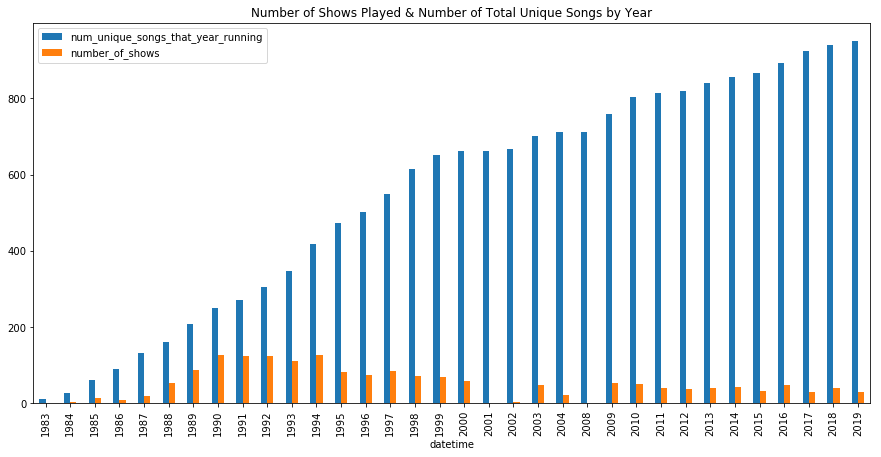

In [256]:
songs_year_df[['num_unique_songs_that_year_running', 'number_of_shows']].plot(kind='bar',figsize=(15,7),
                                                                              title='Number of Shows Played & Number of Total Unique Songs by Year')

In [257]:
songs_year_df

,setlistdata_clean,all_songs,all_unique_songs,num_unique_songs_that_year,all_unique_songs_running,num_unique_songs_that_year_running,number_of_shows
datetime,,,,,,,
1983,[Set 1|Long Cool Woman in a Black Dress|Proud ...,Set 1|Long Cool Woman in a Black Dress|Proud M...,"{Squeeze Box, Scarlet Begonias, Long Cool Woma...",10,"[Squeeze Box, Scarlet Begonias, Long Cool Woma...",10,1
1984,"[Set 1|Makisupa Policeman, Set 1|In the Midnig...",Set 1|Makisupa Policeman|Set 1|In the Midnight...,"{Skippy the Wondermouse, Cities, Don't Want Yo...",22,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",28,3
1985,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Skippy the Wondermouse, Cities, Mike's Song, ...",51,"[Squeeze Box, Skippy the Wondermouse, Cities, ...",60,13
1986,[Set 1|Slave to the Traffic Light|Mike's Song|...,Set 1|Slave to the Traffic Light|Mike's Song|D...,"{Wilson, Slipknot!, Shaggy Dog, Cities, Mike's...",60,"[Squeeze Box, David Bowie, Whipping Post, Pigg...",91,9
1987,[Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en R...,Set 1|Wilson|Set 2|I Am Hydrogen|Peaches en Re...,"{Fuck Your Face, Terrapin, David Bowie, Whippi...",92,"[Squeeze Box, Fuck Your Face, Terrapin, David ...",131,20
1988,[Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Pos...,Set 1|Funky Bitch|Mustang Sally|AC/DC Bag|Poss...,"{No Dogs Allowed, On Your Way Down, Terrapin, ...",106,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",161,53
1989,"[Set 1|Dear Mrs. Reagan, Set 1|I Didn't Know|G...",Set 1|Dear Mrs. Reagan|Set 1|I Didn't Know|Gol...,"{Terrapin, On Your Way Down, No Dogs Allowed, ...",133,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",208,87
1990,[Set 1|Carolina|The Sloth|Bathtub Gin|You Enjo...,Set 1|Carolina|The Sloth|Bathtub Gin|You Enjoy...,"{Terrapin, No Dogs Allowed, David Bowie, Whipp...",119,"[Squeeze Box, Fuck Your Face, No Dogs Allowed,...",249,127
1991,[Set 1|My Sweet One|Foam|Tweezer|Tweezer Repri...,Set 1|My Sweet One|Foam|Tweezer|Tweezer Repris...,"{Terrapin, Brother, David Bowie, Whipping Post...",125,"[Squeeze Box, Fuck Your Face, Terrapin, No Dog...",271,124


In [26]:
songs_year_df

NameError: name 'songs_year_df' is not defined

# Remove bad years for new dataset

In [3]:
all_setlists = src.util.load_pickle_object(r'../data/raw/extract-10082019/all_setlists.pkl')

In [6]:
all_setlists.head()

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Friday 12/02/1983,3.8387,36 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"Trey, Mike, Fish, and Jeff Holdsworth recall b...",12/02/1983,1983-12-02,1251253100,http://phish.net/setlists/phish-december-02-19...,"<a href=""http://phish.net/venue/7/Harris-Milli...",7,Set 1|Long Cool Woman in a Black Dress|Proud M...
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-octo...,"Burlington, VT, USA",Tuesday 10/23/1984,4.1667,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,"This show, played in the garage of a house on ...",10/23/1984,1984-10-23,1250613219,http://phish.net/setlists/phish-october-23-198...,"<a href=""http://phish.net/venue/46/69_Grant_St...",46,Set 1|Makisupa Policeman
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-nove...,"Burlington, VT, USA",Saturday 11/03/1984,3.1351,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"The setlist for this show might be incomplete,...",11/03/1984,1984-11-03,1251262142,http://phish.net/setlists/phish-november-03-19...,"<a href=""http://phish.net/venue/246/Slade_Hall...",246,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Saturday 12/01/1984,3.7200,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,Skippy and Fluffhead featured The Dude of Life...,12/01/1984,1984-12-01,1251262498,http://phish.net/setlists/phish-december-01-19...,"<a href=""http://phish.net/venue/2/Nectar%27s"">...",2,Set 1|Jam|Wild Child|Bertha|Can't You Hear Me ...
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-febr...,"Burlington, VT, USA",Friday 02/01/1985,4.3333,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,It is unconfirmed if this setlist is correct f...,02/01/1985,1985-02-01,1251587227,http://phish.net/setlists/phish-february-01-19...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Slave to the Traffic Light|Mike's Song|D...


In [14]:
all_setlists['date'] = pd.to_datetime(all_setlists.short_date)

In [15]:
all_setlists.head()

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean,date
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Friday 12/02/1983,3.8387,36 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"Trey, Mike, Fish, and Jeff Holdsworth recall b...",12/02/1983,1983-12-02,1251253100,http://phish.net/setlists/phish-december-02-19...,"<a href=""http://phish.net/venue/7/Harris-Milli...",7,Set 1|Long Cool Woman in a Black Dress|Proud M...,1983-12-02
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-octo...,"Burlington, VT, USA",Tuesday 10/23/1984,4.1667,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,"This show, played in the garage of a house on ...",10/23/1984,1984-10-23,1250613219,http://phish.net/setlists/phish-october-23-198...,"<a href=""http://phish.net/venue/46/69_Grant_St...",46,Set 1|Makisupa Policeman,1984-10-23
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-nove...,"Burlington, VT, USA",Saturday 11/03/1984,3.1351,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"The setlist for this show might be incomplete,...",11/03/1984,1984-11-03,1251262142,http://phish.net/setlists/phish-november-03-19...,"<a href=""http://phish.net/venue/246/Slade_Hall...",246,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...,1984-11-03
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Saturday 12/01/1984,3.7200,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,Skippy and Fluffhead featured The Dude of Life...,12/01/1984,1984-12-01,1251262498,http://phish.net/setlists/phish-december-01-19...,"<a href=""http://phish.net/venue/2/Nectar%27s"">...",2,Set 1|Jam|Wild Child|Bertha|Can't You Hear Me ...,1984-12-01
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-febr...,"Burlington, VT, USA",Friday 02/01/1985,4.3333,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,It is unconfirmed if this setlist is correct f...,02/01/1985,1985-02-01,1251587227,http://phish.net/setlists/phish-february-01-19...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Slave to the Traffic Light|Mike's Song|D...,1985-02-01


In [17]:
all_setlists['year'] = all_setlists['date'].map(lambda x: x.year)

In [19]:
all_setlists.shape

(1752, 18)

In [23]:
# I chose >=1999 because this is the year when they had >2/3 of all their current songs
# note the number of shows goes from 1752 --> 640 because of this.
src.util.create_pickle_object(all_setlists[all_setlists.year >= 1999], 'all_setlists_after99.pkl', '../data/raw/extract-10082019/')

Successfully pickled all_setlists_after99.pkl to /Users/anreed/Documents/My Stuff/TrAI/phish-setlist-modeling/data/raw/extract-10082019/all_setlists_after99.pkl


In [25]:
all_setlists[all_setlists.year >= 1999].shape

(640, 18)

In [27]:
all_setlists

,artist,artistid,gapchart,location,long_date,rating,relative_date,setlistdata,setlistnotes,short_date,showdate,showid,url,venue,venueid,setlistdata_clean,date,year
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Friday 12/02/1983,3.8387,36 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"Trey, Mike, Fish, and Jeff Holdsworth recall b...",12/02/1983,1983-12-02,1251253100,http://phish.net/setlists/phish-december-02-19...,"<a href=""http://phish.net/venue/7/Harris-Milli...",7,Set 1|Long Cool Woman in a Black Dress|Proud M...,1983-12-02,1983
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-octo...,"Burlington, VT, USA",Tuesday 10/23/1984,4.1667,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,"This show, played in the garage of a house on ...",10/23/1984,1984-10-23,1250613219,http://phish.net/setlists/phish-october-23-198...,"<a href=""http://phish.net/venue/46/69_Grant_St...",46,Set 1|Makisupa Policeman,1984-10-23,1984
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-nove...,"Burlington, VT, USA",Saturday 11/03/1984,3.1351,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"The setlist for this show might be incomplete,...",11/03/1984,1984-11-03,1251262142,http://phish.net/setlists/phish-november-03-19...,"<a href=""http://phish.net/venue/246/Slade_Hall...",246,Set 1|In the Midnight Hour|Wild Child|Jam|Bert...,1984-11-03,1984
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-dece...,"Burlington, VT, USA",Saturday 12/01/1984,3.7200,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,Skippy and Fluffhead featured The Dude of Life...,12/01/1984,1984-12-01,1251262498,http://phish.net/setlists/phish-december-01-19...,"<a href=""http://phish.net/venue/2/Nectar%27s"">...",2,Set 1|Jam|Wild Child|Bertha|Can't You Hear Me ...,1984-12-01,1984
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-febr...,"Burlington, VT, USA",Friday 02/01/1985,4.3333,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,It is unconfirmed if this setlist is correct f...,02/01/1985,1985-02-01,1251587227,http://phish.net/setlists/phish-february-01-19...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Slave to the Traffic Light|Mike's Song|D...,1985-02-01,1985
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Monday 03/04/1985,2.6452,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,This show was an African Relief benefit for OX...,03/04/1985,1985-03-04,1249948445,http://phish.net/setlists/phish-march-04-1985-...,"<a href=""http://phish.net/venue/10/Hunt%27s"">H...",10,Set 1|Anarchy|Camel Walk|Fire Up the Ganja|Ski...,1985-03-04,1985
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Friday 03/08/1985,4.0000,35 years ago,<p><span class='set-label'>Set 1</span>: <a ti...,This show featured the first known performance...,03/08/1985,1985-03-08,1251587664,http://phish.net/setlists/phish-march-08-1985-...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Sneakin' Sally Through the Alley,1985-03-08,1985
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-marc...,"Burlington, VT, USA",Saturday 03/16/1985,2.0000,35 years ago,<p><span class='set-label'>Set 1</span>: <a hr...,"During the jam, cartoons were shown behind the...",03/16/1985,1985-03-16,1251587687,http://phish.net/setlists/phish-march-16-1985-...,"<a href=""http://phish.net/venue/344/Doolin%27s...",344,Set 1|Alumni Blues|Skippy the Wondermouse|Bert...,1985-03-16,1985
0,<a href='http://phish.net/setlists/phish'>Phis...,1,http://phish.net/setlists/gap-chart/phish-apri.

In [28]:
proc_data = src.process.preprocess_data(all_setlists)

1455 of the 1752 setlists have a Set 1, Set 2, and an Encore section



In [32]:
src.util.create_pickle_object(proc_data[-150:], 'most_recent_150.pkl', '../data/reporting/')

Successfully pickled most_recent_150.pkl to /Users/anreed/Documents/My Stuff/TrAI/phish-setlist-modeling/data/reporting/most_recent_150.pkl


In [31]:
os.getcwd()

'/Users/anreed/Documents/My Stuff/TrAI/phish-setlist-modeling/notebooks'